# **LSTM with Quantization**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from google.colab import files
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch.optim

# import quantization from torch
import torch.quantization

## **Dataset**
This is a kaggle dataset describing air pollution at the US embassy in Beijing, China: https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate.

In [ ]:
# Load the dataset
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/LSTM-Multivariate_pollution.csv', index_col='date')
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Get the name of the uploaded file
df = pd.read_csv(file_name, index_col='date')

df.ffill(inplace=True)

features = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
target = 'pollution'


# One hot encoding to change wind direction values to numerical values
df = pd.get_dummies(df, columns=['wnd_dir'], prefix=['wnd_dir'])
features = df.columns.tolist()
features.remove(target)

# Scale features
for feature in features:
    if feature.startswith('wnd_dir'): # Skip encoded column
        continue
    min_val = df[feature].min()
    max_val = df[feature].max()
    df[feature] = (df[feature] - min_val) / (max_val - min_val)


data = df[features + [target]].values

# Create sequences
def create_sequences(data, seq_length, num_predictions = 3):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - num_predictions - 1):
        x = data[i:(i + seq_length), :]
        y = data[i + seq_length: i + seq_length + num_predictions, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)

seq_length = 10
num_predictions = 3
X, y = create_sequences(data, seq_length, num_predictions)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

Saving LSTM-Multivariate_pollution.csv to LSTM-Multivariate_pollution (1).csv


## **Preparing Dataloaders**

In [ ]:
class AirPollutionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split dataset into train and test sets
train_size = int(len(X) * 0.8)
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = y[:train_size], y[train_size:]

train_dataset = AirPollutionDataset(trainX, trainY)
test_dataset = AirPollutionDataset(testX, testY)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, prefetch_factor=3)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataset = AirPollutionDataset(X, y)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

## **Defining LSTM Model**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_num):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_num)
        self.leakyrelu = nn.LeakyReLU() # Regular ReLU was causing my model to predict all zeroes (possibly from neurons dying?) so I'm trying to use leaky relu instead
        # Leaky relu allows for small negative, non-zero gradient inputs
        # Regular relu was also causing my model max out the available ram

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :]) # applies dropout only on the output
        out = self.fc(out)
        out = self.leakyrelu(out)
        return out

# Instantiate the model
input_size = X.shape[2]
hidden_size = 50
num_layers = 2
output_size = num_predictions # Outputs 3 future values for pollution level
dropout_num = 0.1 # 10% will be dropped
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_num)

# **Model Training**

In [ ]:
import gc
train_losses = []

# Define loss function and optimizer
criterion = nn.MSELoss() # using Mean Squared Error
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)  # Experimenting with the AdamW optimizer
# I chose 0.01 as the learning rate as it took significantly longer at a lr of 0.001 and inaccurate at 0.1
scheduler = StepLR(optimizer, step_size=5, gamma=0.1) # adding a step decay scheduler, every 5 epochs, reduce by a factor of 10

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    gc.collect()
    epoch_train_loss = 0
    for batch_idx, (data, target_sequence) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target_sequence)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # clips gradients
        optimizer.step()
        epoch_train_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(data_loader)}], Loss: {loss.item():.4f}')
    train_losses.append(epoch_train_loss / len(train_loader))
    scheduler.step()

Epoch [1/10], Batch [1/1369], Loss: 0.3464
Epoch [1/10], Batch [101/1369], Loss: 0.0214
Epoch [1/10], Batch [201/1369], Loss: 0.0133
Epoch [1/10], Batch [301/1369], Loss: 0.0103
Epoch [1/10], Batch [401/1369], Loss: 0.0111
Epoch [1/10], Batch [501/1369], Loss: 0.0086
Epoch [1/10], Batch [601/1369], Loss: 0.0079
Epoch [1/10], Batch [701/1369], Loss: 0.0106
Epoch [1/10], Batch [801/1369], Loss: 0.0085
Epoch [1/10], Batch [901/1369], Loss: 0.0048
Epoch [1/10], Batch [1001/1369], Loss: 0.0062
Epoch [2/10], Batch [1/1369], Loss: 0.0069
Epoch [2/10], Batch [101/1369], Loss: 0.0050
Epoch [2/10], Batch [201/1369], Loss: 0.0051
Epoch [2/10], Batch [301/1369], Loss: 0.0044
Epoch [2/10], Batch [401/1369], Loss: 0.0061
Epoch [2/10], Batch [501/1369], Loss: 0.0043
Epoch [2/10], Batch [601/1369], Loss: 0.0069
Epoch [2/10], Batch [701/1369], Loss: 0.0020
Epoch [2/10], Batch [801/1369], Loss: 0.0045
Epoch [2/10], Batch [901/1369], Loss: 0.0040
Epoch [2/10], Batch [1001/1369], Loss: 0.0053
Epoch [3/10]

# **Model Evaluation**

In [ ]:
# Tests the model on the test set and finds loss

def eval_model(model, test_loader, criterion):
  model.eval()
  total_loss = 0
  num_batches = 0
  losses = []
  with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
      output = model(data)
      loss = criterion(output, target.unsqueeze(1))
      total_loss += loss.item()
      num_batches += 1
      losses.append(loss.item())

  avg_loss = total_loss / num_batches
  print(f"Test Loss: {avg_loss:.4f}")
  test_rmse = torch.sqrt(torch.tensor(avg_loss))
  print(f"Test RMSE: {test_rmse.item():.4f}")

  plt.plot(losses)
  plt.title('Test Loss Over Time')
  plt.xlabel('Batch')
  plt.ylabel('Loss')
  plt.show()

loss = eval_model(model, test_loader, criterion)

NameError: name 'criterion' is not defined

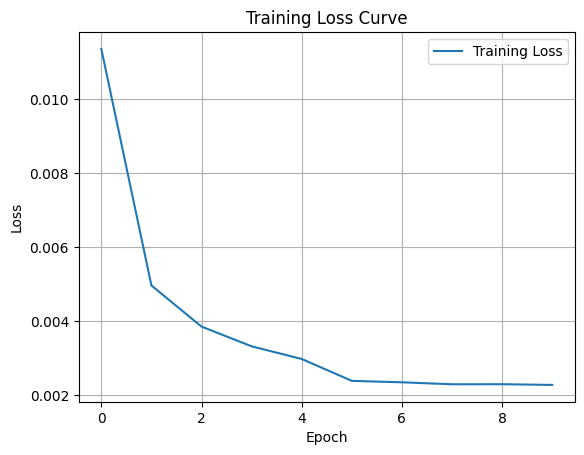

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

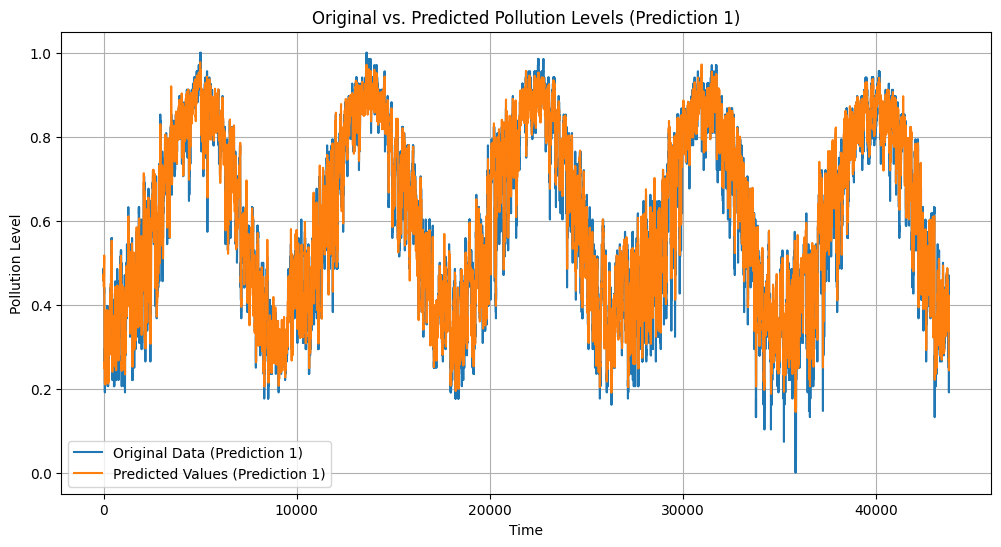

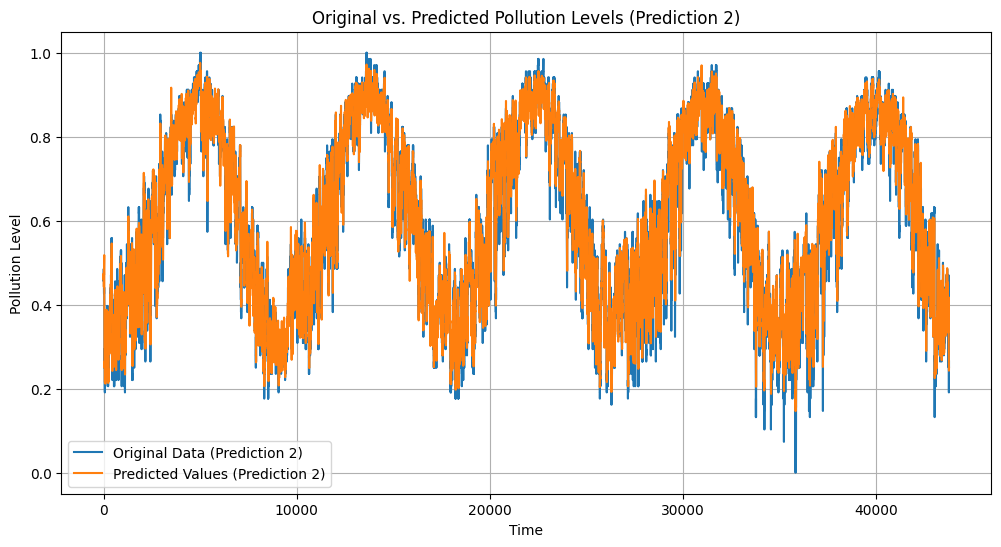

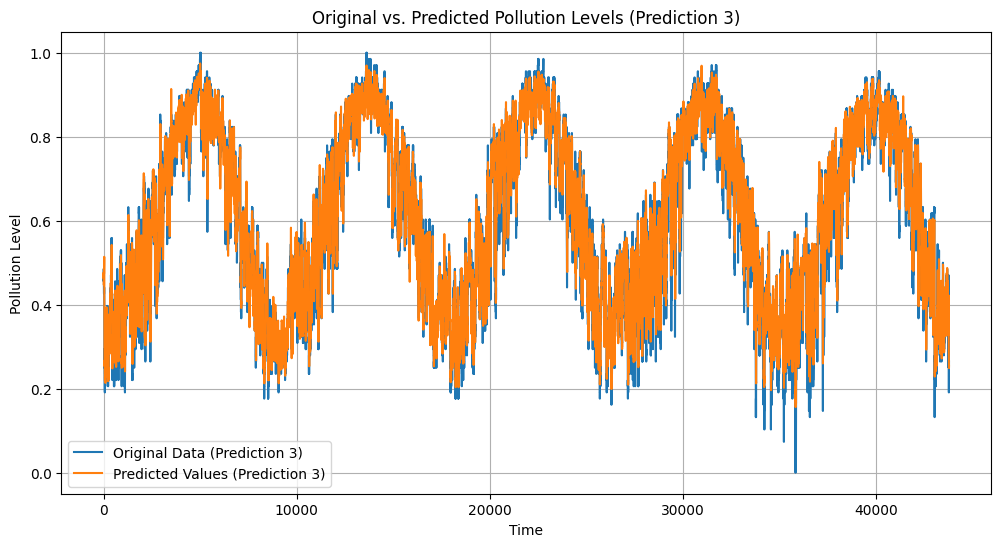

In [ ]:
# Get predictions on the entire dataset
model.eval()
with torch.no_grad():
    all_predictions = model(X)

predicted_values = all_predictions.cpu().numpy()
original_values = y.cpu().numpy()

# Plot for each num_prediction
for i in range(num_predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(original_values[:, i], label=f'Original Data (Prediction {i + 1})')
    plt.plot(predicted_values[:, i], label=f'Predicted Values (Prediction {i + 1})')
    plt.xlabel('Time')
    plt.ylabel('Pollution Level')
    plt.title(f'Original vs. Predicted Pollution Levels (Prediction {i + 1})')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_optimized.pth')
# files.download('model_optimized.pth')

# **Post Training Quantization (PTQ)**

Post Training Quantization (PTQ) uses a set of calibration data to initialize quantization with activation scaling factors.

In [ ]:
# Prepare calibration dataset and loader so I can calibrate my quantized model
calibration_dataset = torch.utils.data.Subset(train_dataset, indices=range(0, len(train_dataset) // 30)) # 30% of data used for calibration
calibration_loader = torch.utils.data.DataLoader(calibration_dataset, batch_size=32, shuffle=False) # Same dataloader as always

# Define calibration function
def calibrate_model(model, calibration_loader):
    model.eval() # set model to evaluation mode
    with torch.no_grad(): # calibration only involves forward passes so no gradient updates
        for data, target in calibration_loader:
            model(data) # performs forward pass on batches of data in the calibration_loader


In [ ]:
# Load pretrained model
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_num)
model.load_state_dict(torch.load('model_optimized.pth'))
model.eval()

LSTMModel(
  (lstm): LSTM(11, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
)

In [ ]:
# Send the recurrent LSTM layer and fully connected layer as they are the most computationally expensive so benefit the most from quantization
quantized_model = torch.quantization.quantize_dynamic(model, {nn.LSTM, nn.Linear}, dtype=torch.qint8)
calibrate_model(quantized_model, calibration_loader)

Test Loss: 0.0806
Test RMSE: 0.2840


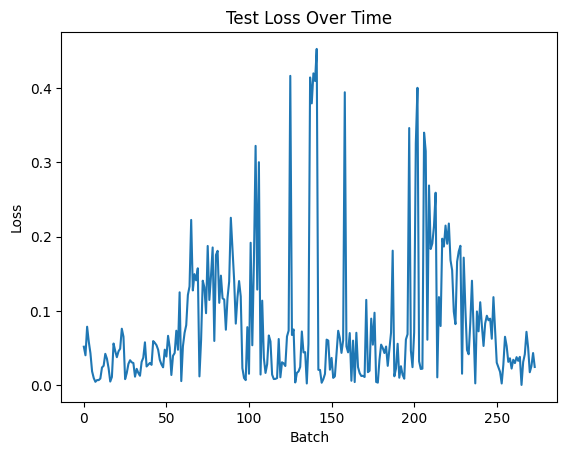

In [ ]:
# Uses the eval_model method I created above to evaluate my loss and RMSE
eval_model(quantized_model, test_loader, criterion)

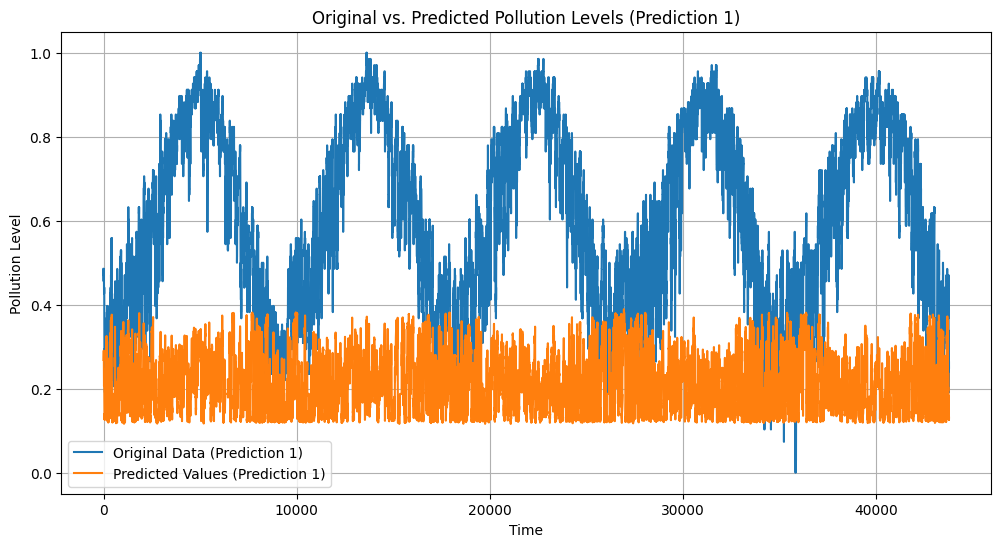

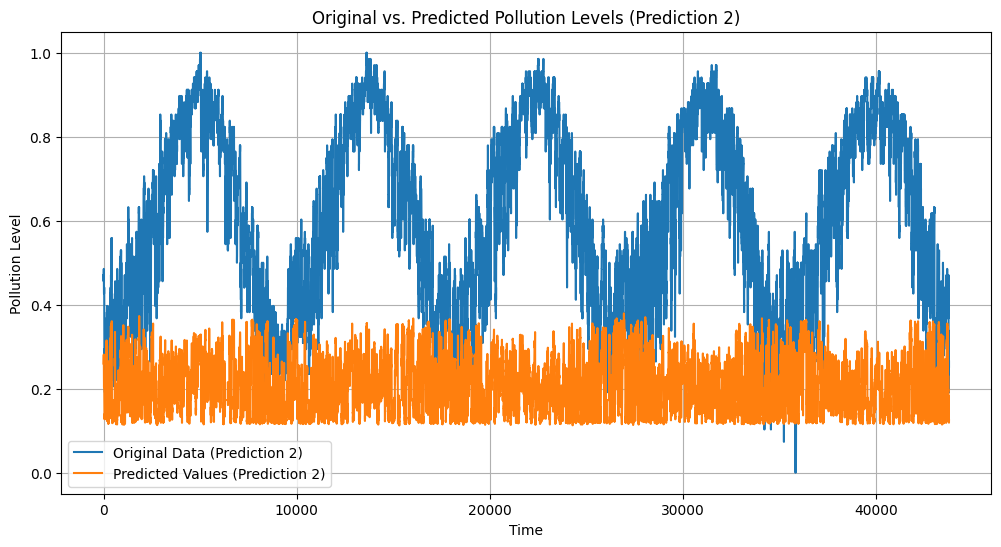

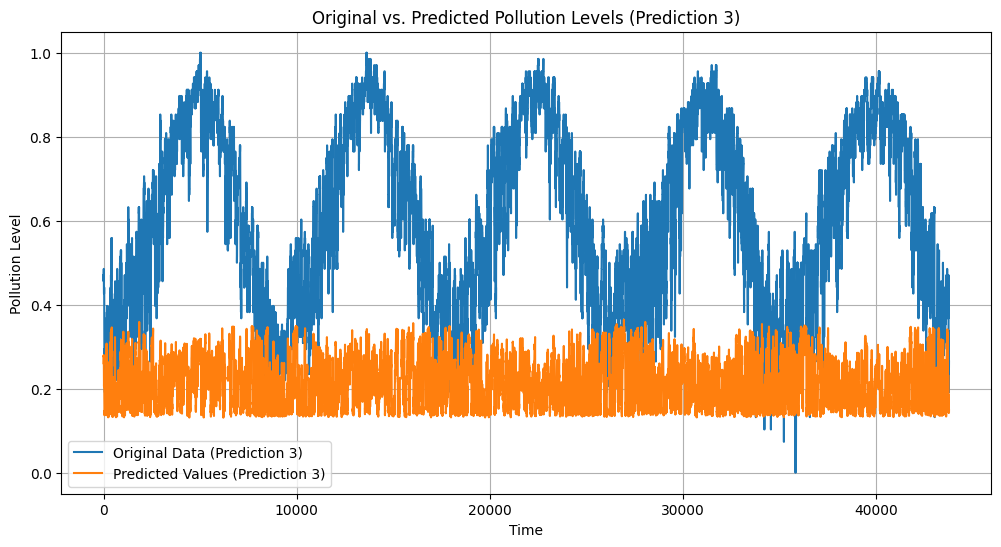

In [ ]:
# Get predictions on the entire dataset with the quantized model
model.eval()
with torch.no_grad():
    all_predictions = quantized_model(X)

predicted_values = all_predictions.cpu().numpy()
original_values = y.cpu().numpy()

# Plot for each num_prediction
for i in range(num_predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(original_values[:, i], label=f'Original Data (Prediction {i + 1})')
    plt.plot(predicted_values[:, i], label=f'Predicted Values (Prediction {i + 1})')
    plt.xlabel('Time')
    plt.ylabel('Pollution Level')
    plt.title(f'Original vs. Predicted Pollution Levels (Prediction {i + 1})')
    plt.legend()
    plt.grid(True)
    plt.show()

As you can see, the quantized model greatly undershoots its predictions. This is most likely because of the loss in precision due to compression. LSTM models are especially susceptible to this due to their recurrent nature. This particular model has a relatively small dataset as well, meaning that any loss in precision will cause large changes in its predictions.

In [ ]:
import os
# Save the original model
torch.save(model.state_dict(), 'original_model.pth')

# Save the quantized model
torch.save(quantized_model.state_dict(), 'quantized_model.pth')

# Get file sizes (in bytes)
original_size = os.path.getsize('original_model.pth')
quantized_size = os.path.getsize('quantized_model.pth')

# Prints out comparison metric for size
print(f"Original model size: {original_size} bytes")
print(f"Quantized model size: {quantized_size} bytes")
print(f"Size reduction: {(original_size - quantized_size) / original_size * 100:.2f}%")

Original model size: 136218 bytes
Quantized model size: 40562 bytes
Size reduction: 70.22%


Test Loss: 0.0045
Test RMSE: 0.0667


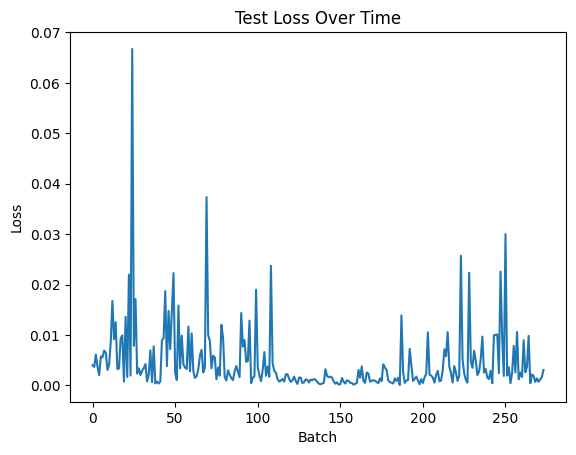

Test Loss: 0.0806
Test RMSE: 0.2840


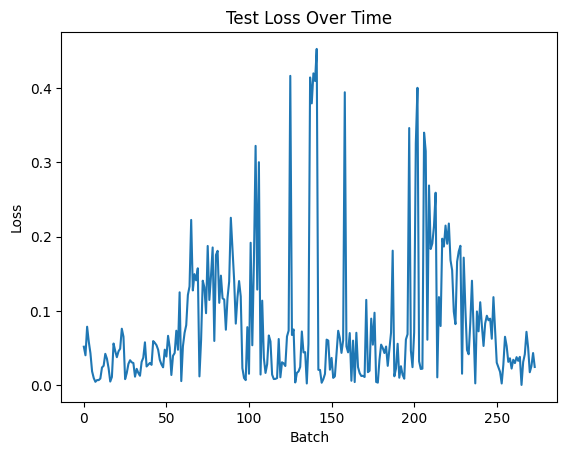

In [ ]:
# Evaluate the original model
original_rmse = eval_model(model, test_loader, criterion)

# Evaluate the quantized model
quantized_rmse = eval_model(quantized_model, test_loader, criterion)

As can be seen, the RMSE goes up significantly. This is due to the fact that quantization conerts the 32-bit numbers representing the orignal weights to 8-bit numbers of lower precision but smaller size. This likely causes information loss that leads to an increase in RMSE.

In [ ]:
import os

# check model file sizes
original_size = os.path.getsize("original_model.pth") / 1024 # KB
quantized_size_PTDQ = os.path.getsize("quantized_model.pth") / 1024 # KB

print(f"Original model size: {original_size:.2f} KB")
print(f"Quantized model size (PTDQ): {quantized_size_PTDQ:.2f} KB")
print(f"Compression Ratio (PTDQ): {original_size / quantized_size_PTDQ:.2f}x")

Original model size: 133.03 KB
Quantized model size (PTDQ): 39.61 KB
Compression Ratio (PTDQ): 3.36x
